# 3. Redes Convolucionales en Google Street View

## 3a. 
El codigo siguiente cargue los datos, da información sobre ellos, y muestra 5 imágenes aleatorias de cada conjunto.

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random

def make_sets():
    train_data = sio.loadmat('train_32x32.mat')
    test_data = sio.loadmat('test_32x32.mat')
    X_train = train_data['X'].T
    y_train = train_data['y'] - 1
    X_test = test_data['X'].T
    y_test = test_data['y'] - 1
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    return (X_train, y_train), (X_test, y_test)
(X_train, y_train), (X_test, y_test) = make_sets()
(n_images,n_channels, n_rows, n_cols) = X_train.shape
classes, counts = np.unique(y_train,return_counts=True)
n_classes = len(classes)
print('\nDimension of the images: {}x{}'.format(n_rows,n_cols))
print('Number of different classes: {}'.format(n_classes))


Training set:
13861 examples of class 0
10585 examples of class 1
8497 examples of class 2
7458 examples of class 3
6882 examples of class 4
5727 examples of class 5
5595 examples of class 6
5045 examples of class 7
4659 examples of class 8
4948 examples of class 9
5 random photos from this set:


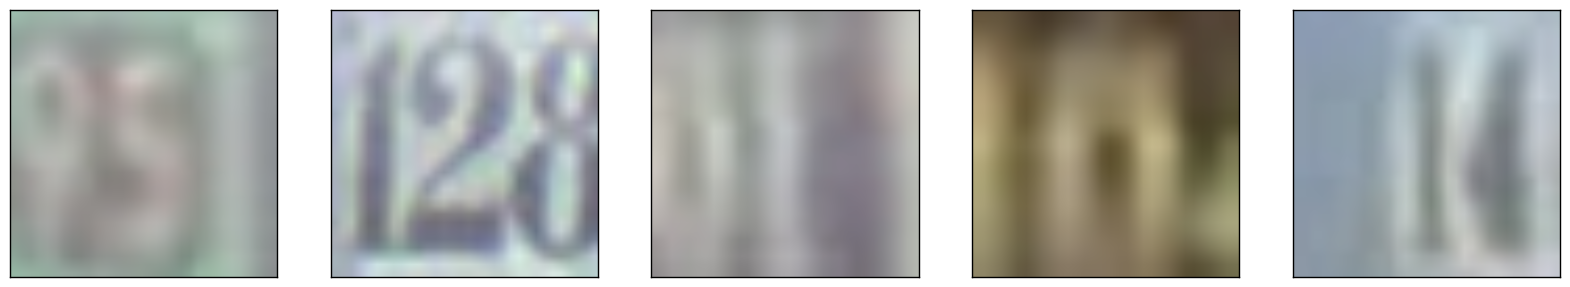


Testing set:
5099 examples of class 0
4149 examples of class 1
2882 examples of class 2
2523 examples of class 3
2384 examples of class 4
1977 examples of class 5
2019 examples of class 6
1660 examples of class 7
1595 examples of class 8
1744 examples of class 9
5 random photos from this set:


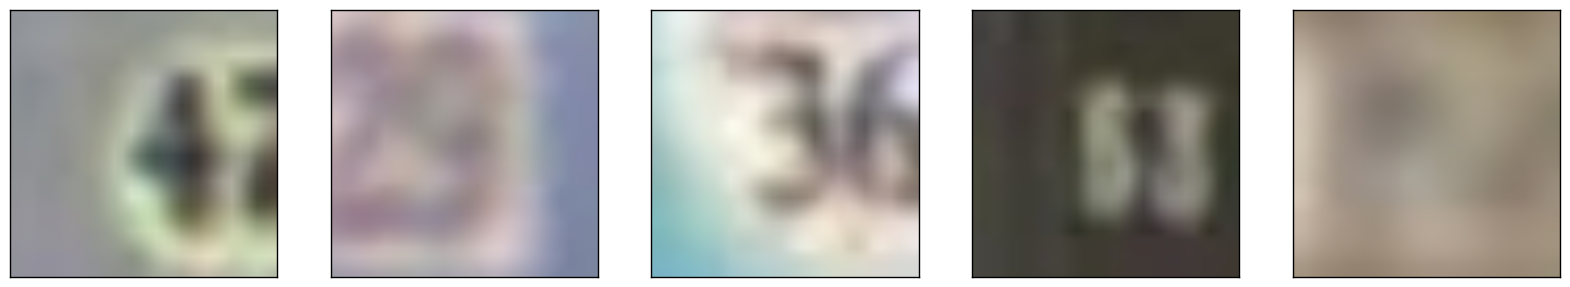

In [4]:
def get_info(set_X,set_y, n=5):
    N = set_X.shape[0]
    classes, counts = np.unique(set_y,return_counts=True)
    for i in range(len(classes)):
        print('{} examples of class {}'.format(counts[i],classes[i]))
    rand_photos =  random.sample(range(N), n)
    plt.figure(figsize=(20, 4))
    print('5 random photos from this set:')
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        phot = rand_photos[i]
        plt.imshow(set_X[phot,:,:,:].T)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    return
print('\nTraining set:')
get_info(X_train,y_train)
print('\nTesting set:')
get_info(X_test,y_test)


Podemos ver que las imágenes son de muy mala calidad, y que a veces también para un humano es difícil ver cuales números son en las imágenes. También parece que más una cifra es grande, menos ella aparece. Eso es lógico, porque los números vienen de números de casas en calles, y como los números son asignados en orden creciente en cada calle, los más pequeños aparecen mas frequentamente que los mas grandes.

## 3b. 
El codigo siguiente normalice los datos y pone las categorías en la forma que puede usar la funcion fit.

In [6]:
from keras.utils import np_utils
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

## 3c.
El codigo siguiente define una CNN que permite reconocer números del conjunto SVHN.

In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad

model = Sequential()
model.add(Convolution2D(16, 5, 5, border_mode='same', activation='relu',input_shape=(n_channels, n_rows, n_cols)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(512, 7, 7, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 32, 32)    1216        convolution2d_input_14[0][0]     
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 16, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 512, 16, 16)   401920      maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 512, 8, 8)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

En la entrada de la red, tenemos imágenes de color de 32 por 32 píxeles, entonces los tensores de entrada son de forma 3x32x32. La primera capa de convolución tiene 16 filtros, y cada uno genera una 'imagen' de 32 por 32 píxeles en salida. Por eso los tensores de salida de esa capa son de forma 16x32x32. La primera capa de MaxPooling reduzca la dimensionalidad, tomando el pixel de valor máxima en cada cuadrito de dimension 2x2, entonces divisa por 2 ambas dimensiones de cada imagen (y divisa la imágen total en 4). En la salida de esa capa, todavía hay 16 imágenes, pero ahora, cada una es de dimensión 16x16, entonces los tensores de salida son de forma 16x16x16. La secunda capa de convolución tiene 512 filtros, y no cambia el tamaño de las imagenes, por eso sus tensores de salida son de forma 512x16x16. De nuevo, la secunda capa de MaxPooling divisa por 2 el tamaño de ambas dimensiones de cada imágen, lo que resulta en tensores de tamaño 512x8x8. La capa Flatten, toma todos los datos y les pone en una sola dimensión. Finalmente, las capas Dense simplemente reduzcan el tamaño del vector hasta 20 y 10 respectivamente. Por eso tenemos 10 salidas, que corresponden a las 10 cifras.

Podemos observar que cada capa de convolución aumenta la dimensionalidad, y que cada capa de MaxPooling la reduzca. Las capas de convolución aumentan el numero de channels, y las capas de MaxPooling reduzcan el tamaño de cada imágen. Una manera de verlo, es como imágenes que tienen menos y menos píxeles, pero donde cada pixel tiene mas y mas informacion, empezando con muchos píxeles que solo tienen una color cada uno, y terminando con un sólo pixel que contiene toda la información de la imagen que nos interesa (en este caso: el número).

## 3d.
El código siguiente entrena la red y muestre su precisión y el tiempo que toma.

In [14]:
import time
def cnn_svhn(img_data,cf_size,cf2_size,cp_size,n_filters_l1,n_filters_l2,nb_epoch,verbose):
    (X_train,Y_train,X_test,Y_test) = img_data
    (n_images,n_channels, n_rows, n_cols) = X_train.shape
    model = Sequential()
    model.add(Convolution2D(n_filters_l1, cf_size,  cf_size,  border_mode='same', activation='relu',
                                                           input_shape=(n_channels, n_rows, n_cols)))
    model.add(MaxPooling2D(pool_size=(cp_size, cp_size)))
    model.add(Convolution2D(n_filters_l2, cf2_size, cf2_size, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(cp_size, cp_size)))
    model.add(Flatten())
    model.add(Dense(20, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer=Adagrad(), metrics=['accuracy'])
    start = time.time()
    h = model.fit(X_train, Y_train, batch_size=1280, nb_epoch=nb_epoch, verbose=verbose, validation_data=(X_test, Y_test))
    stop  = time.time()
    t     = stop - start
    accuracy = h.history['val_acc'][-1]
    return accuracy, t, h, model

Train on 73257 samples, validate on 26032 samples
Epoch 1/12
73257/73257 [==============================] - 1381s - loss: 0.3823 - acc: 0.8964 - val_loss: 0.3165 - val_acc: 0.9001
Epoch 2/12
73257/73257 [==============================] - 1345s - loss: 0.2718 - acc: 0.9058 - val_loss: 0.2446 - val_acc: 0.9125
Epoch 3/12
73257/73257 [==============================] - 1343s - loss: 0.2096 - acc: 0.9239 - val_loss: 0.1853 - val_acc: 0.9325
Epoch 4/12
73257/73257 [==============================] - 1336s - loss: 0.1663 - acc: 0.9390 - val_loss: 0.1579 - val_acc: 0.9433
Epoch 5/12
73257/73257 [==============================] - 1300s - loss: 0.1410 - acc: 0.9493 - val_loss: 0.1364 - val_acc: 0.9517
Epoch 6/12
73257/73257 [==============================] - 1242s - loss: 0.1247 - acc: 0.9559 - val_loss: 0.1241 - val_acc: 0.9576
Epoch 7/12
73257/73257 [==============================] - 1225s - loss: 0.1118 - acc: 0.9613 - val_loss: 0.1220 - val_acc: 0.9589
Epoch 8/12
73257/73257 [================

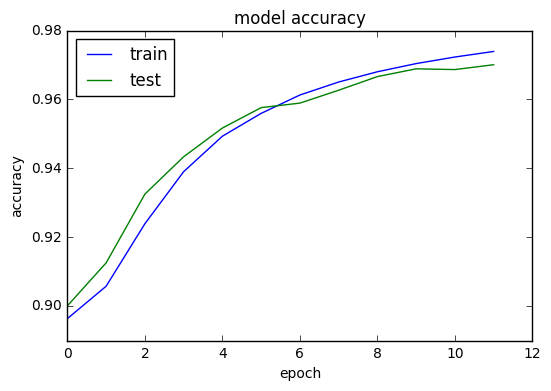

In [12]:
img_data = (X_train,Y_train,X_test,Y_test)
accuracy, t, h, model = cnn_svhn(img_data,cf_size=5,cf2_size=7,cp_size=2,
                                 n_filters_l1=16,n_filters_l2=512,nb_epoch=12,verbose=1)
model.save('q3d.h5')
print('Accuracy:{0:.2f}%'.format(accuracy*100))
print('Time:{0:.2f} seconds'.format(t))
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3e.
El código siguiente entrena la misma red con diferentes tamaños de filtros de las capas convolucionales y de MaxPooling

In [ ]:
cf_sizes = [3,5,7]
for i in range(len(cf_sizes)):
    cf_size = cf_sizes[i]
    accuracy, t, h, model = cnn_svhn(img_data,cf_size,cf_size,2,16,512,10,verbose=0)
    model.save('q3ecf_size'+str(cf_size)+'.h5')
accuracy, t, h, model = cnn_svhn(img_data,5,5,4,16,512,10,verbose=0)
model.save('q3ecp_size4.h5')

In [9]:
from keras.models import load_model
cf_sizes = [3,5,7]
times = [4467.21,7594.16,12719.12]
for i in range(len(cf_sizes)):
    t = times[i]
    cf_size = cf_sizes[i]
    model = load_model('q3ecf_size'+str(cf_size)+'.h5')
    out = model.evaluate(X_test, Y_test, batch_size=1280, verbose=0)
    accuracy = out[1]
    print('\nTesting with convolution filter of size {}x{} and MaxPooling filter of size 2x2:'.format(cf_size,cf_size))
    print('Training of the NN for 10 epochs took {0:.2f}s and reached {1:.2f}% accuracy'.format(t,accuracy*100))

t = 2636.43
model = load_model('q3ecp_size4.h5')
out = model.evaluate(X_test, Y_test, batch_size=1280, verbose=0)
accuracy = out[1]
print('\nTesting with convolution filter of size 5x5 and MaxPooling filter of size 4x4:')
print('Training of the NN for 10 epochs took took {0:.2f}s and reached {1:.2f}% accuracy'.format(t,accuracy*100))


Testing with convolution filter of size 3x3 and MaxPooling filter of size 2x2:
Training of the NN for 10 epochs took 4467.21s and reached 93.86% accuracy

Testing with convolution filter of size 5x5 and MaxPooling filter of size 2x2:
Training of the NN for 10 epochs took 7594.16s and reached 94.89% accuracy

Testing with convolution filter of size 7x7 and MaxPooling filter of size 2x2:
Training of the NN for 10 epochs took 12719.12s and reached 83.92% accuracy

Testing with convolution filter of size 5x5 and MaxPooling filter of size 4x4:
Training of the NN for 10 epochs took took 2636.43s and reached 92.00% accuracy


## 3f.
El codigo siguiente entrena la misma red con diferentes números de filtros para las capas convolucionales.

In [ ]:
accuracy, t, h, model = cnn_svhn(img_data,5,5,2,32,64,10,verbose=0)
model.save('q3f_32_64.h5')
    
accuracy, t, h, model = cnn_svhn(img_data,5,5,2,8,64,10,verbose=0)
model.save('q3f_8_64.h5')

In [10]:
t = 3748.83
model = load_model('q3f_32_64.h5')
out = model.evaluate(X_test, Y_test, batch_size=1280, verbose=0)
accuracy = out[1]
print('\nTesting with 32 and 64 filters respectively for the convolution layers')
print('Training of the NN for 10 epochs took took {0:.2f}s and reached {1:.2f}% accuracy'.format(t,accuracy*100))

t = 1421.62
model = load_model('q3f_8_64.h5')
out = model.evaluate(X_test, Y_test, batch_size=1280, verbose=0)
accuracy = out[1]
print('\nTesting with 8 and 64 filters respectively for the convolution layers')
print('Training of the NN for 10 epochs took took {0:.2f}s and reached {1:.2f}% accuracy'.format(t,accuracy*100))


Testing with 32 and 64 filters respectively for the convolution layers
Training of the NN for 10 epochs took took 3748.83s and reached 96.34% accuracy

Testing with 8 and 64 filters respectively for the convolution layers
Training of the NN for 10 epochs took took 1421.62s and reached 93.77% accuracy


## 3g.
El codigo siguiente entrena una red parecida a las redes previas, pero con 2 capas de convolución antes de cada capa de pooling.

In [13]:
model = Sequential()
model.add(Convolution2D(32, 3, 3,border_mode='same',activation='relu',input_shape=(3,32,32)))
model.add(Convolution2D(32, 3, 3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_15[0][0]     
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 32, 30, 30)    9248        convolution2d_3[0][0]            
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 32, 15, 15)    0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 256, 15, 15)   73984       maxpooling2d_3[0][0]             
___________________________________________________________________________________________

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 73257 samples, validate on 26032 samples
Epoch 1/10
73257/73257 [==============================] - 1931s - loss: 2.5605 - acc: 0.8389 - val_loss: 2.5781 - val_acc: 0.8392
Epoch 2/10
73257/73257 [==============================] - 1896s - loss: 2.5994 - acc: 0.8378 - val_loss: 2.5781 - val_acc: 0.8392
Epoch 3/10
73257/73257 [==============================] - 2192s - loss: 2.5994 - acc: 0.8378 - val_loss: 2.5781 - val_acc: 0.8392
Epoch 4/10
73257/73257 [==============================] - 2192s - loss: 2.5994 - acc: 0.8378 - val_loss: 2.5781 - val_acc: 0.8392
Epoch 5/10
73257/73257 [==============================] - 2319s - loss: 2.5994 - acc: 0.8378 - val_loss: 2.5781 - val_acc: 0.8392
Epoch 6/10
73257/73257 [==============================] - 2079s - loss: 2.5994 - acc: 0.8378 - val_loss: 2.5781 - val_acc: 0.8392
Epoch 7/10
73257/73257 [==============================] - 2413s - loss: 2.5994 - acc: 0.8378 - val_loss: 2.5781 - val_acc: 0.8392
Epoch 8/10
73257/73257 [================

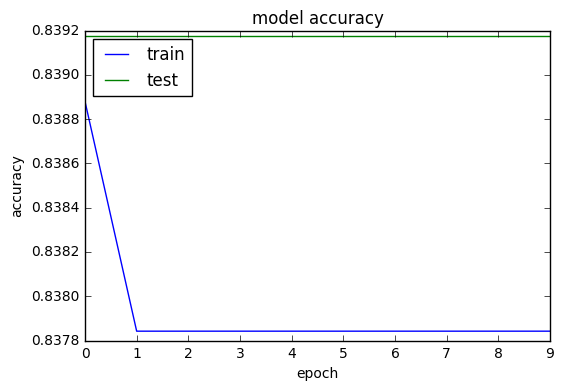

In [17]:
model.compile(loss='binary_crossentropy', optimizer=Adagrad(), metrics=['accuracy'])
start = time.time()
h = model.fit(X_train, Y_train, batch_size=1280, nb_epoch=10, verbose=1, validation_data=(X_test, Y_test))
stop  = time.time()
t     = stop - start
accuracy = h.history['val_acc'][-1]
model.save('q3g.h5')
print('\nTesting with double convolution layers')
print('Training of the NN took {0:.2f}s and reached {1:.2f}% accuracy'.format(t,accuracy*100))
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 3h.
Vamos a visualizar la salida de la primera capa de convolución de una de las redes entrenadas previamente. Eligimos la secunda red de la parte 3f porque es la que tiene la menor cantidad de filtros, pero todavía tiene una precisión resonable. Así la visualisación de las salidas de los filtros será menos pesada. 

Primer, visualisamos los pesos de esa primera capa. Los pesos tienen una forma 8x3x5x5m porque hay 8 filtros, y cada uno tiene pesos para una fentana de 5 por 5 pixeles, con 3 pesos por píxel porque las imágenes de entrada son en RGB.

In [37]:
model = load_model('q3f_8_64.h5')
conv1 = model.layers[0]
weights = conv1.get_weights()
np.set_printoptions(precision=2)
print(weights[0].shape)
print(weights)

(8, 3, 5, 5)
[array([[[[-0.14, -0.04,  0.05, -0.12,  0.01],
         [-0.03, -0.12,  0.03, -0.09, -0.07],
         [ 0.09,  0.05,  0.04, -0.01, -0.07],
         [ 0.09, -0.1 ,  0.05, -0.05,  0.06],
         [-0.02, -0.08,  0.13, -0.02, -0.1 ]],

        [[ 0.04,  0.06,  0.1 ,  0.07, -0.09],
         [-0.1 ,  0.02,  0.09, -0.09,  0.04],
         [ 0.1 , -0.08,  0.01, -0.12, -0.14],
         [-0.02,  0.03, -0.04,  0.1 ,  0.09],
         [ 0.11, -0.09, -0.11,  0.01, -0.14]],

        [[ 0.09, -0.16,  0.12, -0.15, -0.13],
         [ 0.13,  0.04,  0.1 , -0.06,  0.09],
         [-0.01, -0.16, -0.05,  0.08, -0.11],
         [ 0.06, -0.15, -0.02,  0.03,  0.05],
         [-0.13,  0.07, -0.07,  0.07, -0.05]]],


       [[[-0.04,  0.08, -0.14, -0.07, -0.02],
         [ 0.08, -0.14, -0.01, -0.01, -0.  ],
         [ 0.1 , -0.03, -0.05, -0.09,  0.08],
         [-0.1 ,  0.11,  0.1 , -0.1 , -0.14],
         [-0.08, -0.06,  0.03, -0.1 ,  0.03]],

        [[-0.14, -0.02, -0.01, -0.02, -0.12],
         [

Ahora, visualisemos las salidas del primer filtro: la primera imágen de cada columna es la imagen de entrada original, y las 8 imágenes siguientes son las salidas de los 8 filtros de la capa de convolución.

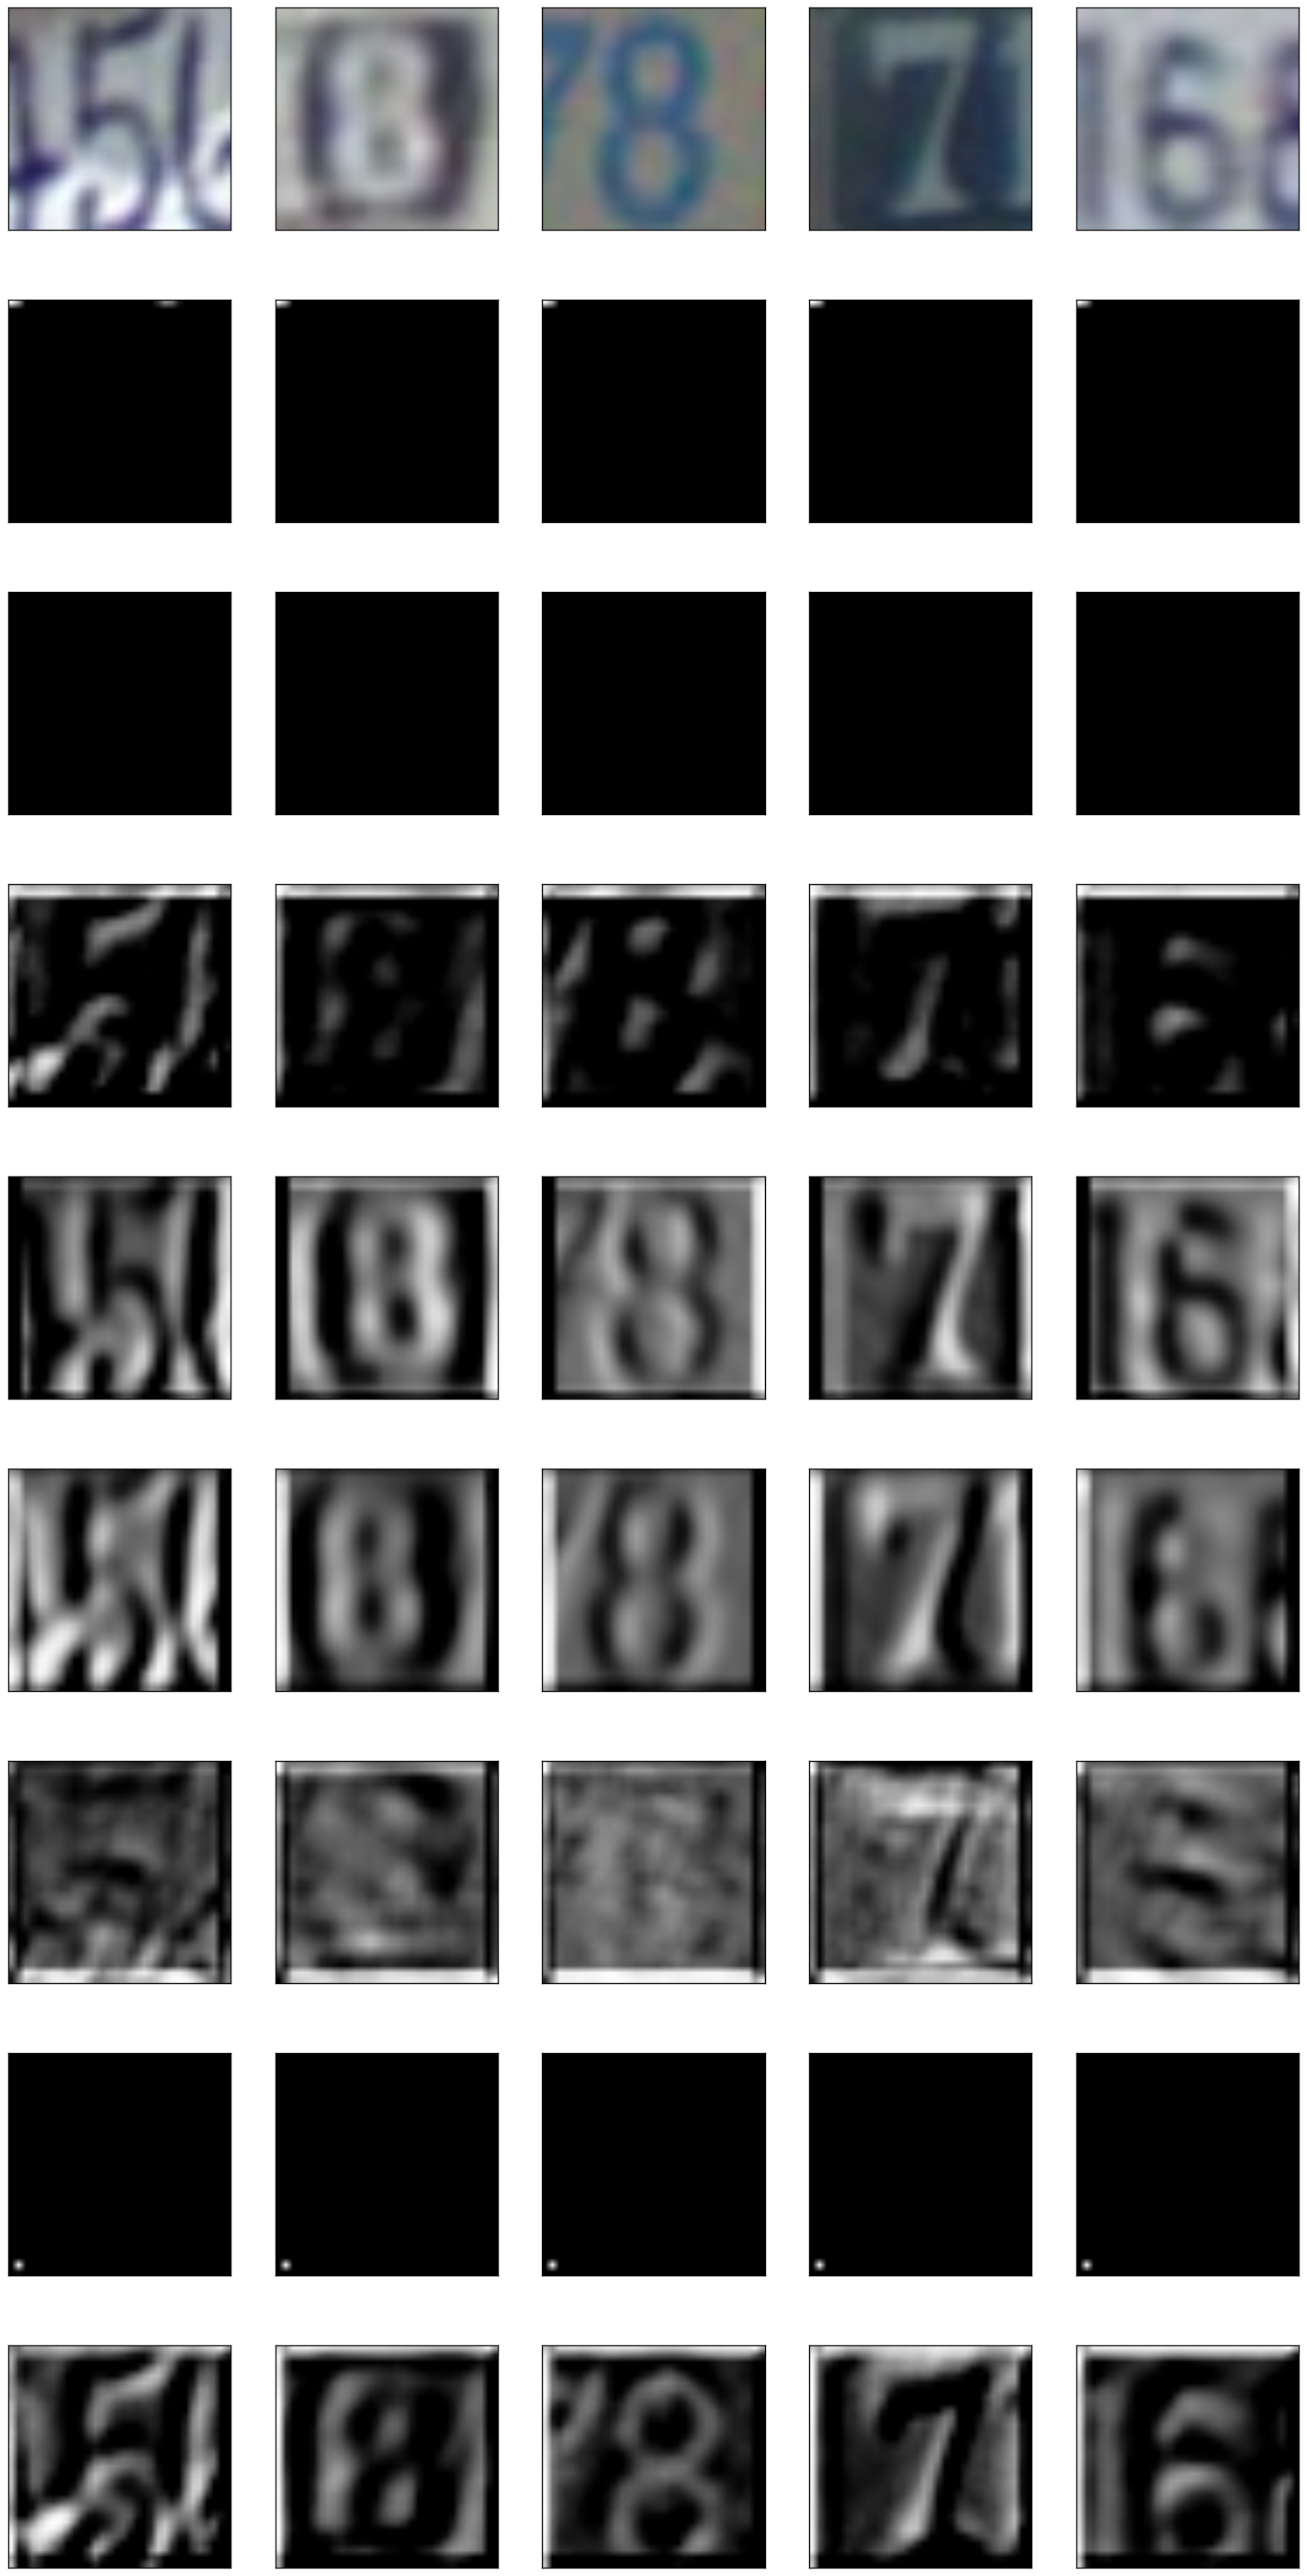

In [41]:
N = X_train.shape[0]
n = 5
rand_photos =  random.sample(range(N), n)

model = Sequential()
model.add(Convolution2D(8, 5, 5,border_mode='same',activation='relu', input_shape=(3, 32, 32),weights=weights))
out = model.predict_on_batch(X_train[rand_photos,:,:,:])

plt.figure(figsize=(20, 40))
for i in range(n):
    ax = plt.subplot(9, n, i + 1)
    phot = rand_photos[i]
    plt.imshow(X_train[phot,:,:,:].T)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for j in range(8):
        ax = plt.subplot(9,n,i+1 + n*(j+1))
        img = out[i,j,:,:]
        plt.imshow(img.T, cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

Podemos ver que según las imágenes, se puede reconocer la cifras más facilmente sobre algún filtro que sobre los otros. Por ejemplo, la ultima imagen se puede reconocer claramente unicamente sobre et 4to filtro, ver la tercera y cuarta imagen se pueden reconocer bien sobre el último filtro. Eso suggera que cada filtro se especializa para reconocer imágenes de un cierto tipo, y por eso es útil tener muchos filtros, porque las imágenes pueden tomar muchas formas diferentes (color de número, color de fondo, a veces color atrás del fondo, borrosidad,...) 